In [76]:
# Analysis of CCLE gene expression data for LOY and dependencies (suggested by Andy Lane)
# Final analyses and figures for manuscript
# 7-14-22
# Esther Rheinbay

import sys
import pandas as pd
import numpy as np
import re

from scipy.stats import ttest_ind, spearmanr, norm, ks_2samp, mannwhitneyu, fisher_exact
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [77]:
palette = {'Male':'cadetblue', 'Female':'palevioletred', 'Unknown':'palegoldenrod'}

In [78]:
# CCLE sample info and expression data
# file source: https://depmap.org/portal/download/all/?releasename=DepMap+Public+22Q2&filename=sample_info.csv
sample_info = pd.read_csv(sample_info.csv', sep=',', header=0, index_col=0) 

# "full" expression that has XIST
# files source: https://depmap.org/portal/download/all/?releasename=DepMap+Public+22Q2&filename=CCLE_expression_full.csv
ccle_exp = pd.read_csv('CCLE_expression_full_22Q2.csv', sep=',', header=0, index_col=0)

# trim column names to just gene names: 
ccle_exp.columns = map(lambda x: x.split(' ')[0], ccle_exp.columns.values)


In [79]:
# drop Y genes with no info or aliases
ccle_exp.drop(columns=['AC009977.1', 'ANOS2P', 'AC006157.1', 'AC009078.1', 'AC010889.1'], inplace=True)

In [80]:
# updated dependencies 
# file source https://depmap.org/portal/download/all/?releasename=DepMap+Public+22Q2&filename=CRISPR_gene_effect.csv
dependencies = pd.read_csv('CRISPR_gene_effect.csv', sep=',', header=0, index_col=0) 
dependencies.columns = map(lambda x: x.split(' ')[0], dependencies.columns.values)



In [82]:
# expressed Y genes identified elsewhere (7-gene signature)
expressed_Y_genes =['DDX3Y', 'EIF1AY' , 'KDM5D',   'RPS4Y1',  'USP9Y', 'UTY', 'ZFY']

In [83]:
# calculate chrY average
avg_Y_exp = ccle_exp[expressed_Y_genes].apply(lambda x: np.nanmean(x), axis=1)
avg_Y_exp = pd.merge(avg_Y_exp.to_frame(name='avg_Y_exp'), sample_info[['CCLE_Name', 'sex', 'primary_disease']], left_index = True, right_index = True)

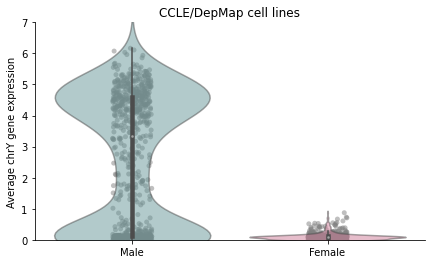

In [84]:
# distribution of average chrY expression in male and female cell lines
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
sns.violinplot(x = 'sex', y = 'avg_Y_exp', data=avg_Y_exp, orient='v',alpha=0.3, zorder=1, scale='width', palette=palette)
sns.stripplot(x = 'sex', y = 'avg_Y_exp', data=avg_Y_exp, color ='grey', orient='v', alpha=0.2, zorder=0)
plt.setp(ax.collections, alpha=.5)
ax.set_ylabel('Average chrY gene expression')
ax.set_ylim([0,7])
ax.set_title('CCLE/DepMap cell lines') 
ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Aha! First, all cell lines now have an annotated sex, rather than the "Unknown" category. Second, there are no females with chrY expression anymore! Nice they cleaned it up :) 
And it looks like the male A388_SKIN line is not a cervival cancer anymore! 

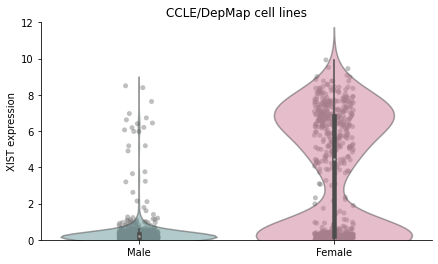

In [101]:
# Plot XIST expression 

XIST = ccle_exp['XIST']
XIST = pd.merge(XIST.to_frame(name='XIST'), sample_info[['CCLE_Name', 'sex', 'primary_disease']], left_index = True, right_index = True)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
sns.violinplot(x = 'sex', y = 'XIST', data=XIST, orient='v',alpha=0.3, zorder=1, scale='width', palette=palette)
sns.stripplot(x = 'sex', y = 'XIST', data=XIST, color ='grey', orient='v', alpha=0.2, zorder=0)
plt.setp(ax.collections, alpha=.5)
ax.set_ylabel('XIST expression')
ax.set_ylim([0,12])
ax.set_title('CCLE/DepMap cell lines') 
ax.set_xlabel('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


Many male cell lines with high XIST, and many female cell lines without XIST! Some germcell tumors express Y and XIST, and females might have LOX or reactivation of silenced X.

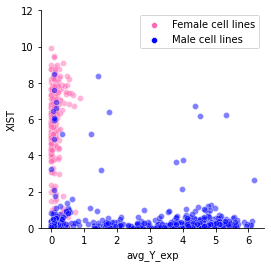

In [100]:
# compare Y exp and XIST for male cell lines with highXIST
avg_Y_exp['XIST'] = avg_Y_exp.apply(lambda x: XIST.loc[x.name].XIST, axis=1)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sns.scatterplot(x = 'avg_Y_exp', y = 'XIST', data = avg_Y_exp[avg_Y_exp.sex=='Female'], color = 'hotpink', label = 'Female cell lines')
sns.scatterplot(x = 'avg_Y_exp', y = 'XIST', data = avg_Y_exp[avg_Y_exp.sex=='Male'], color = 'blue', label = 'Male cell lines')
plt.setp(ax.collections, alpha=.5)
#ax.set_ylabel('XIST expression')
ax.set_ylim([0,12])
#ax.set_title('CCLE/DepMap cell lines with XIST>2') 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [99]:
# still some "male" lines without chrY expression but XIST expression
males_high_XIST_low_Y = avg_Y_exp[(avg_Y_exp.sex=='Male') & (avg_Y_exp.XIST>2) & (avg_Y_exp.avg_Y_exp<1)]
males_high_XIST_low_Y.to_csv(workdir + "Males_high_XIST_low_Y.tsv", sep='\t', header=True, index=True)
males_high_XIST_low_Y

,avg_Y_exp,CCLE_Name,sex,primary_disease,XIST,Y_status
ACH-000008,0.133866,A101D_SKIN,Male,Skin Cancer,5.982081,NA
ACH-000224,0.141585,HS819T_FIBROBLAST,Male,Non-Cancerous,6.620586,NA
ACH-000476,0.071325,JHH4_LIVER,Male,Liver Cancer,6.443109,NA
ACH-000506,0.083099,NCIH146_LUNG,Male,Lung Cancer,2.104337,NA
ACH-000014,0.095067,HS294T_SKIN,Male,Skin Cancer,5.972463,NA
ACH-000393,0.085672,HLF_LIVER,Male,Liver Cancer,6.065658,NA
ACH-001970,0.000000,MM253_SKIN,Male,Skin Cancer,3.228049,NA
ACH-001067,0.343695,F5_CENTRAL_NERVOUS_SYSTEM,Male,Brain Cancer,5.191405,NA
ACH-000564,0.081337,KHM1B_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,Male,Myeloma,4.903038,NA
ACH-000480,0.150404,HUH7_LIVER,Male,Liver Cancer,6.966015,NA


In [89]:
# what are those "intermediate" male lines?
avg_Y_exp[(avg_Y_exp.sex=='Male') & (avg_Y_exp.XIST>2) & (avg_Y_exp.avg_Y_exp>1) &(avg_Y_exp.avg_Y_exp<2)]

,avg_Y_exp,CCLE_Name,sex,primary_disease,XIST
ACH-000871,1.509213,NCIH510_LUNG,Male,Lung Cancer,3.195348
ACH-000603,1.216389,BEN_LUNG,Male,Lung Cancer,5.185470
ACH-000610,1.440213,NCIH2227_LUNG,Male,Lung Cancer,8.396391
ACH-000844,1.752130,DMS454_LUNG,Male,Lung Cancer,6.408202


Per cellosaurus, NCIH510_LUNG has only Amelogenin X; BEN_LUNG X or X,Y; NCIH2227_LUNG only X; DMS454_LUNG X,Y.

In [90]:
# "Good" sets of male wt and fLOY lines
males_low_Y =  avg_Y_exp[(avg_Y_exp.sex=='Male') & (avg_Y_exp.XIST<2) & (avg_Y_exp.avg_Y_exp<1)].index
males_wt_Y = avg_Y_exp[(avg_Y_exp.sex=='Male') & (avg_Y_exp.XIST<2) & (avg_Y_exp.avg_Y_exp>=1)].index

# low_Y definition of <1 (no females are above 1, use this as reference)
avg_Y_exp['Y_status'] = avg_Y_exp.apply(lambda x: 'low_Y' if x.name in males_low_Y else ('withY' if x.name in males_wt_Y else 'NA'), axis=1)
avg_Y_exp.to_csv("All_CCLE_Y_exp_22Q2.txt", sep='\t')

primary_disease             Y_status
Bile Duct Cancer            withY       12
                            low_Y        4
Bladder Cancer              withY       11
                            low_Y        8
Bone Cancer                 withY       16
                            low_Y        2
Brain Cancer                withY       43
                            low_Y       13
Colon/Colorectal Cancer     low_Y       22
                            withY       19
Embryonal Cancer            low_Y        1
Endometrial/Uterine Cancer  withY        2
Esophageal Cancer           low_Y       18
                            withY        6
Eye Cancer                  low_Y        2
                            withY        2
Gallbladder Cancer          low_Y        3
Gastric Cancer              low_Y       15
                            withY        8
Head and Neck Cancer        withY       26
                            low_Y       18
Kidney Cancer               withY       12
                 

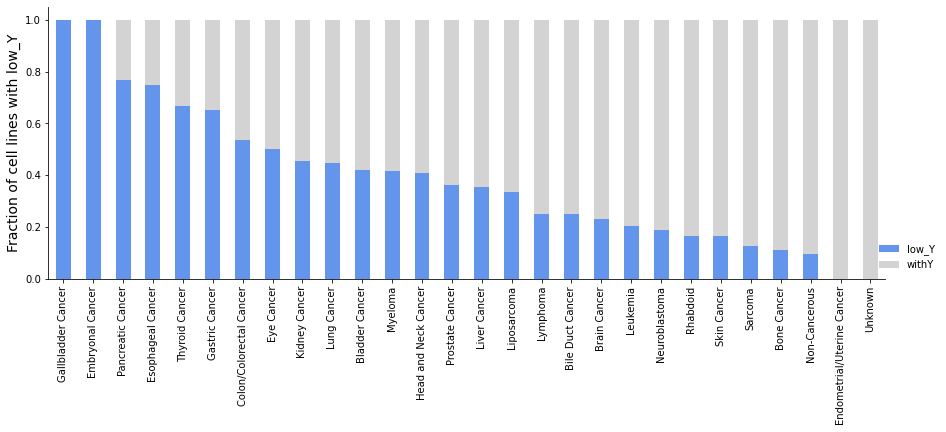

In [91]:
# barplot of male cell lines with LOY by tumor type - take with keeping the total numbers in mind

print(avg_Y_exp[(avg_Y_exp.sex=='Male') & (avg_Y_exp.Y_status.isin(['low_Y', 'withY']))].groupby('primary_disease').Y_status.value_counts())

df = (avg_Y_exp[(avg_Y_exp.sex=='Male') & (avg_Y_exp.Y_status.isin(['low_Y', 'withY']))].groupby('primary_disease').Y_status.value_counts()/avg_Y_exp[(avg_Y_exp.sex=='Male')& (avg_Y_exp.Y_status.isin(['low_Y', 'withY']))].groupby('primary_disease').Y_status.count()).unstack()
df.replace(np.nan, 0, inplace=True)
order = df.sort_values(by = 'low_Y', ascending=False).index

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
df.loc[order][['low_Y', 'withY']].plot.bar(stacked=True, ax=ax, color= {'withY':'lightgrey', 'low_Y':'cornflowerblue'})
ax.legend(bbox_to_anchor=(1.07, 0), frameon=False,  loc= 'lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Fraction of cell lines with low_Y', fontsize=14)
ax.set_xlabel('');


In [92]:
# differential gene expression between fLOY and with Y
ccle_exp_transposed = ccle_exp.transpose()
males_low_Y_exp_overlap = [x for x in males_low_Y if x in ccle_exp_transposed.columns] 
males_with_Y_exp_overlap = [x for x in males_wt_Y if x in ccle_exp_transposed.columns] 

diff_exp = ccle_exp_transposed.apply(lambda x: ttest_ind(x[males_low_Y_exp_overlap], x[males_with_Y_exp_overlap], nan_policy='omit').pvalue, axis=1).to_frame()
diff_exp.columns = ['ttest_p']
diff_exp['avg_low_Y'] = diff_exp.apply(lambda x: np.nanmean(ccle_exp_transposed.loc[x.name][males_low_Y_exp_overlap]), axis=1)
diff_exp['avg_with_Y'] = diff_exp.apply(lambda x: np.nanmean(ccle_exp_transposed.loc[x.name][males_with_Y_exp_overlap]), axis=1)
diff_exp['FD'] = diff_exp.apply(lambda x: float(x.avg_low_Y)/float(max(x.avg_with_Y,0.0001)), axis=1)

diff_exp_reduced = diff_exp.dropna()
diff_exp_reduced['qval'] = fdrcorrection(diff_exp_reduced.ttest_p)[1]

/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_16586/2454017580.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_exp_reduced['qval'] = fdrcorrection(diff_exp_reduced.ttest_p)[1]


/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_16586/2174318975.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  chrY_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_16586/2174318975.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  par_genes =pd.read_csv('/Users/esther/Documents/Projects/2019/chrY/PAR_genes/chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)
/Users/esther/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/esther/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylik

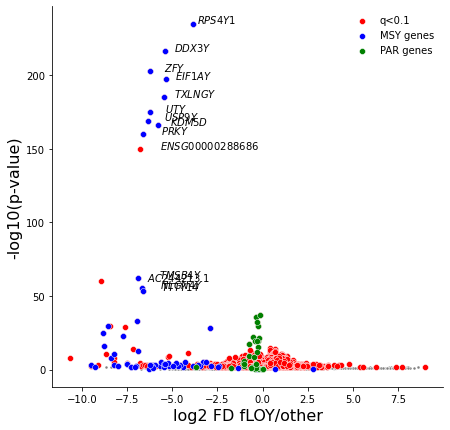

In [93]:
# volcano plot for differential gene expression

chrY_genes =pd.read_csv('chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
par_genes =pd.read_csv('chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)
exp_Y_genes = [x for x in chrY_genes if x in diff_exp_reduced.index]
exp_Y_genes.append('HSFY3P')

exp_par_genes = [x for x in par_genes if x in diff_exp_reduced.index]

# volcano plot for expressioon LOY cell lines
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x = np.log2(diff_exp_reduced.FD), y = -np.log10(diff_exp_reduced.ttest_p), color='grey', marker = '.', ax=ax)
sns.scatterplot(x = np.log2(diff_exp_reduced[diff_exp_reduced.qval<0.1].FD), y = -np.log10(diff_exp_reduced[diff_exp_reduced.qval<0.1].ttest_p), color='red', label = 'q<0.1')
sns.scatterplot(x = np.log2(diff_exp_reduced.loc[exp_Y_genes].FD), y = -np.log10(diff_exp_reduced.loc[exp_Y_genes].ttest_p), marker = 'o', color='blue', label = 'MSY genes')
sns.scatterplot(x = np.log2(diff_exp_reduced.loc[exp_par_genes].FD), y = -np.log10(diff_exp_reduced.loc[exp_par_genes].ttest_p), marker = 'o', color='green', label = 'PAR genes')

# indicate significance threshold
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in diff_exp_reduced[diff_exp_reduced.ttest_p<1e-50].iterrows():
    ax.text(np.log2(row.FD+0.01), -np.log10(row.ttest_p)+0.01, '$\it{' + row.name + '}$')
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('-log10(p-value)', fontsize=16)
ax.set_xlabel('log2 FD fLOY/other', fontsize=16)

In [94]:
# Dependency analysis
males_low_Y_exp_overlap = [x for x in males_low_Y if x in dependencies.index]
males_with_Y_exp_overlap = [x for x in males_wt_Y if x in dependencies.index]
dep_transposed = dependencies.transpose()

Y_dependencies = dep_transposed.apply(lambda x: ttest_ind(x[males_low_Y_exp_overlap], x[males_with_Y_exp_overlap], nan_policy='omit').pvalue, axis=1).to_frame()
Y_dependencies.columns = ['ttest_p']
Y_dependencies['avg_low_Y'] = Y_dependencies.apply(lambda x: np.nanmean(dep_transposed.loc[x.name][males_low_Y_exp_overlap]), axis=1)
Y_dependencies['avg_with_Y'] = Y_dependencies.apply(lambda x: np.nanmean(dep_transposed.loc[x.name][males_with_Y_exp_overlap]), axis=1)
Y_dependencies['difference'] = Y_dependencies.apply(lambda x: x.avg_low_Y-x.avg_with_Y, axis=1)
Y_dependencies['qval'] = fdrcorrection(Y_dependencies.ttest_p)[1]



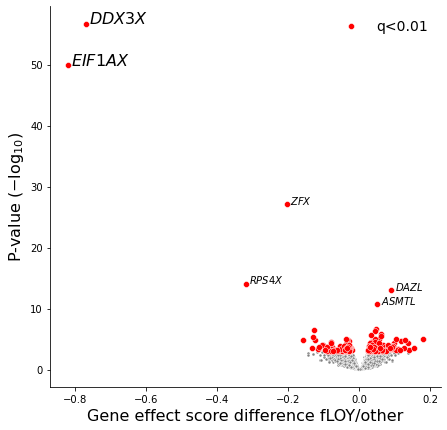

In [95]:
# volcano plot for dependencies for LOY cell lines
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x = Y_dependencies.difference, y = -np.log10(Y_dependencies.ttest_p), color='grey', marker = '.', ax=ax)
sns.scatterplot(x = Y_dependencies[Y_dependencies.qval<0.1].difference, y = -np.log10(Y_dependencies[Y_dependencies.qval<0.1].ttest_p), color='red', label = 'q<0.01')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in Y_dependencies[(Y_dependencies.ttest_p<1e-7) & (Y_dependencies.ttest_p>1e-40)].iterrows():
    ax.text(row.difference+0.01, -np.log10(row.ttest_p)+0.01, '$\it{' + row.name + '}$')
for index, row in Y_dependencies[Y_dependencies.ttest_p<1e-40].iterrows():
    ax.text(row.difference+0.01, -np.log10(row.ttest_p)+0.01, '$\it{' + row.name + '}$', fontsize=16)
ax.legend(loc='upper right', frameon=False, fontsize=14)
ax.set_ylabel('P-value ($\mathregular{-log_{10}}$)', fontsize=16)
ax.set_xlabel('Gene effect score difference fLOY/other', fontsize=16)

/var/folders/z1/t63vz71n5ps4pfkvv_xq061r0000gq/T/ipykernel_16586/3196296891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Y_status'] = df.apply(lambda x: 'fLOY' if x.name in males_low_Y else ('wt' if x.name in males_wt_Y else 'NA'), axis=1)


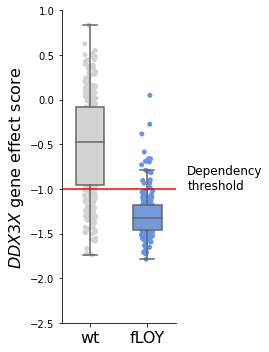

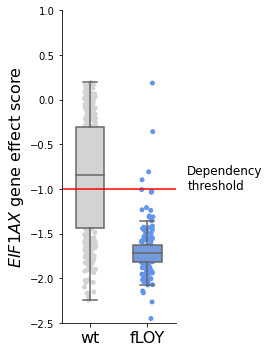

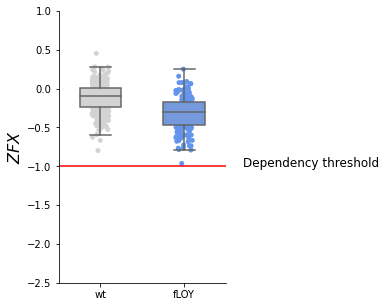

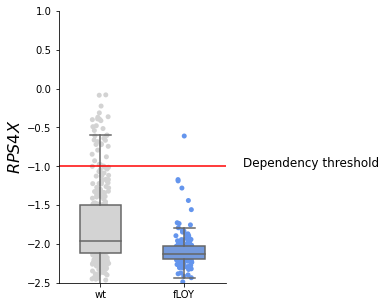

In [96]:
df = dependencies[['DDX3X', 'EIF1AX', 'ZFX', 'RPS4X']]
df['Y_status'] = df.apply(lambda x: 'fLOY' if x.name in males_low_Y else ('wt' if x.name in males_wt_Y else 'NA'), axis=1)

feature = 'DDX3X'
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
sns.stripplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'], alpha=1, zorder=0)
sns.boxplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'],  width=0.5, zorder=1, fliersize=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('$\it{' + feature + '}$' + ' gene effect score', fontsize=16)
ax.hlines(-1, -0.5,1.5, color = 'red')
ax.text(1.7, -1, 'Dependency\nthreshold', fontsize=12)
ax.set_ylim(-2.5, 1)
ax.set_xticklabels(['wt', 'fLOY'], fontsize=16)
plt.tight_layout()


feature = 'EIF1AX'
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
sns.stripplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'], alpha=1, zorder=0)
sns.boxplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'],  width=0.5,  zorder=1, fliersize=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('$\it{' + feature + '}$' + ' gene effect score', fontsize=16)
ax.hlines(-1, -0.5,1.5, color = 'red')
ax.text(1.7, -1, 'Dependency\nthreshold', fontsize=12)
ax.set_ylim(-2.5, 1)
ax.set_xticklabels(['wt', 'fLOY'], fontsize=16)
plt.tight_layout()


feature = 'ZFX'
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.stripplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'], alpha=1, zorder=0)
sns.boxplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'],  width=0.5,  zorder=1, fliersize=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('$\it{' + feature + '}$' , fontsize=16)
ax.hlines(-1, -0.5,1.5, color = 'red')
ax.text(1.7, -1, 'Dependency threshold', fontsize=12)
ax.set_ylim(-2.5, 1)


feature = 'RPS4X'
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.stripplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'], alpha=1, zorder=0)
sns.boxplot(x = 'Y_status', y = feature, data = df[df.Y_status.isin(['fLOY', 'wt'])], palette = ['lightgrey', 'cornflowerblue'],  width=0.5,  zorder=1, fliersize=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('$\it{' + feature + '}$' , fontsize=16)
ax.hlines(-1, -0.5,1.5, color = 'red')
ax.text(1.7, -1, 'Dependency threshold', fontsize=12)
ax.set_ylim(-2.5, 1)

